# Profile data reading
This notebook loads a small number of plates with precomputed features and the metadata information. Pandas, plotly and s3fs packages are required.
## Import libraries

In [1]:
import io
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "notebook_connected" # Set to "svg" or "png" for static plots or "notebook_connected" for interactive plots

## Helper functions

In [2]:
formatter = ('s3://cellpainting-gallery/cpg0016-jump/'
             '{Metadata_Source}/workspace/profiles/'
             '{Metadata_Batch}/{Metadata_Plate}/{Metadata_Plate}.parquet')

def read_parquet_from_s3(s3_path, columns=None):
    dframe = pd.read_parquet(s3_path,
                             storage_options={"anon": True},
                             columns=columns)
    # Force to be string. Needed for merge
    dframe['Metadata_Plate'] = dframe['Metadata_Plate'].astype(str)
    return dframe

## Load metadata

The following files contain the metadata information for the entire dataset.

In [3]:
plates = pd.read_csv('metadata/plate.csv.gz')
wells = pd.read_csv('metadata/well.csv.gz')
library = pd.read_csv('metadata/compound.csv.gz')

## Sample plates
As a way of example we are filtering a particular plate type and sampling 2 plates per source.

In [4]:
sample = plates.query('Metadata_PlateType=="TARGET2"').groupby('Metadata_Source').sample(2, random_state=42)
sample

,Metadata_Source,Metadata_Batch,Metadata_Plate,Metadata_PlateType
1409,source_10,2021_08_03_U2OS_48_hr_run12,Dest210726-160150,TARGET2
1428,source_10,2021_08_09_U2OS_48_hr_run13,Dest210727-153003,TARGET2
191,source_3,CP_31_all_Phenix1,JCPQC028,TARGET2
192,source_3,CP_31_all_Phenix1,JCPQC029,TARGET2
580,source_4,2021_08_30_Batch13,BR00127146,TARGET2
502,source_4,2021_08_02_Batch10,BR00121423,TARGET2
765,source_5,JUMPCPE-20210902-Run26_20210903_010341,ACPJUM141,TARGET2
773,source_5,JUMPCPE-20210903-Run27_20210904_215148,ACPJUM142,TARGET2
872,source_6,p210906CPU2OS48hw384exp025JUMP,110000294881,TARGET2
844,source_6,p210824CPU2OS48hw384exp022JUMP,110000293081,TARGET2


## Loading profiles
Setting `columns = None` will load all of the features.

<div class="alert alert-warning">
WARN: Files are located in S3. This loop loads two features per each sampled plate. For large-scale experiments, we suggest to get a local copy first.
</div>

In [5]:
dframes = []
columns = ['Metadata_Source', 'Metadata_Plate', 'Metadata_Well', 'Cells_AreaShape_Area', 'Nuclei_AreaShape_Area']
for _, row in sample.iterrows():
    s3_path = formatter.format(**row.to_dict())
    dframes.append(read_parquet_from_s3(s3_path, columns=columns))
dframes = pd.concat(dframes)

## Join features with metadata
Now we merge profiles with the metadata to get an annotated DataFrame.

In [6]:
metadata = library.merge(wells, on='Metadata_JCP2022')
ann_dframe = metadata.merge(dframes, on=['Metadata_Source', 'Metadata_Plate', 'Metadata_Well'])

## Plot features
The following scatter plot contains every well in the sampled dataset.

In the interactive plot (see [`imports`](#Import-libraries)), you can hover over the points to see the JCP ID and the InChiKey for a given compound.

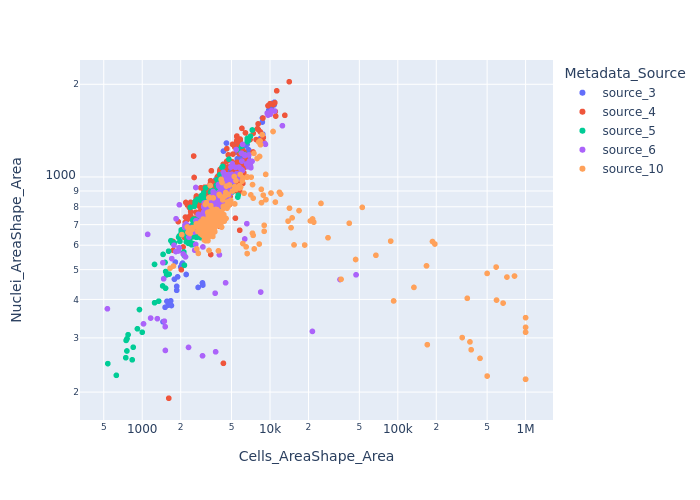

In [7]:
px.scatter(ann_dframe, x='Cells_AreaShape_Area',
           y='Nuclei_AreaShape_Area',
           color='Metadata_Source',
           hover_name='Metadata_JCP2022',
           hover_data=['Metadata_InChIKey'],
           log_x=True, log_y=True)